## Housing Price Prediction

In [255]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf 
import pandas as pd
import statistics as s
import matplotlib.pyplot as plt 
import seaborn as sn
import statsmodels.api as sm
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider, FloatSlider, SelectMultiple, interactive
import numpy as np
import random

In [256]:
%matplotlib inline

In [257]:
#data imputed in R with "missForest" package

random.seed(12345)

data = pd.read_csv("real_estate_data.csv")

data1 = pd.get_dummies(data)

train ,test = train_test_split(data,test_size=0.3) 


print(len(train))
print(len(test))

#NAs are taken care of
print(train.isna().sum())
print(train.info())



1022
438
Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
X3SsnPorch       0
ScreenPorch      0
PoolArea         0
Poo

In [258]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
829,830,160,FV,24.00,2544,Pave,Pave,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,7,2006,WD,Normal,147400.0
149,150,50,RM,54.28,6240,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,4,2006,WD,Normal,115000.0
495,496,30,C (all),60.00,7879,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,GdWo,Shed,0,11,2009,WD,Abnorml,34900.0
740,741,70,RM,60.00,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,GdPrv,Shed,0,5,2007,WD,Abnorml,132000.0
325,326,45,RM,50.00,5000,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,12,2007,WD,Normal,87000.0


## Encoding

Encoding is necessary because for variable selection process. Most of variable selction methods (e.g. Recursive Feature Elimination (RFE) and regularization (Ridge and Lasso) does not support categorical variables. Encoding takes care of this problem as the outcome will turn into binary variable.

In [259]:
dataset = train
#print(dataset.head(5))

d1 = pd.DataFrame(dataset)
d1

#find the columns that are not object
num_df= d1.select_dtypes(include=['int64', 'float64']).copy()
num = pd.DataFrame(num_df)

#find the columns that are object
obj_df = d1.select_dtypes(include=['object']).copy()

obj_col = list(obj_df.columns)

obj = pd.get_dummies(obj_df, columns=obj_col)

#concatenate num and obj
d2 = pd.concat([num, obj], axis = 1)

d2.head()

#list(d2.columns)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
829,830,160,24.00,2544,7,5,2005,2005,0.0,0,...,0,0,0,1,0,0,0,0,1,0
149,150,50,54.28,6240,5,4,1936,1950,0.0,0,...,0,0,0,1,0,0,0,0,1,0
495,496,30,60.00,7879,4,5,1920,1950,0.0,495,...,0,0,0,1,1,0,0,0,0,0
740,741,70,60.00,9600,5,7,1910,2002,0.0,0,...,0,0,0,1,1,0,0,0,0,0
325,326,45,50.00,5000,5,6,1941,1950,0.0,116,...,0,0,0,1,0,0,0,0,1,0


## Variable Selection: Recursive Feature Elimination Method

https://machinelearningmastery.com/feature-selection-machine-learning-python/

As we wanted to pick 20 most important variables, when we ran RFE with all 282 variables (including encoded variables), the result was only giving us encoded variable (which doesn't make any sense). So we decided to run RFE among continuous variables only (the result made more sense).

For the sake of practice, we combined those two results to include in our regression.

In [203]:
#Recursive Feature Elimination Method

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#dropping outcome variable for RFE (continuous variables only)
num1 = num.drop('SalePrice', axis = 1)

xvar = d2.drop('SalePrice', axis = 1)
yvar = d2['SalePrice']

model = LinearRegression()
#select 10 variables that are the most important
rfe = RFE(model, 10)
fit = rfe.fit(num1, yvar)
#fit1 = rfe.fit(xvar, yvar)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
#print("Selected Features: %s" % (fit1.support_))
#print("Feature Ranking: %s" % (fit.ranking_))

rank1 = fit.ranking_
feat = fit.support_

l1=[i for i, x in enumerate(feat) if x]

z1 = []
for v in l1:
    z1.append(d2.columns[v])
z1

Num Features: 10
Selected Features: [False False False False  True  True False False False False False False
 False False False False False  True  True  True False  True  True  True
  True False  True False False False False False False False False False
 False]


['OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars']

In [204]:
#This RFE is including encoded variables (This is selecting only encoded variable! Something is wrong.)
fit1 = rfe.fit(xvar, yvar)
fit1.n_features_
feat1 = fit1.support_

l=[i for i, x in enumerate(feat1) if x]

z = []
for v in l:
    z.append(d2.columns[v])
z

['FireplaceQu_Ex',
 'FireplaceQu_Fa',
 'FireplaceQu_Gd',
 'FireplaceQu_Po',
 'GarageType_Basment',
 'GarageFinish_RFn',
 'GarageQual_TA',
 'Fence_MnWw',
 'MiscFeature_Shed',
 'SaleCondition_Normal']

In [244]:
#selected variables
v_selected = z+z1

#all variables except for SalePrice
v_list = list(d2.columns)
v_list.pop(v_list.index('SalePrice'))
v_list

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'X1stFlrSF',
 'X2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'X3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 '

['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'X1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice']


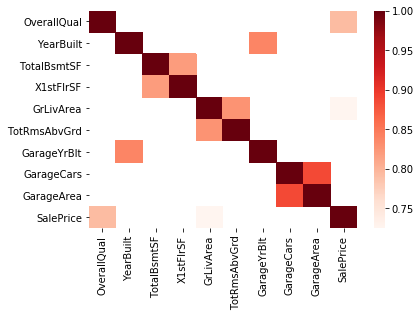

In [6]:
#check for multicolliearity
corr = train.corr()
corr = corr[corr > .7]
corr = corr[corr.sum()>1]
corr1 = corr.filter(corr.sum() > 1, axis = 1)
corr1 = corr1.to_string()
corr1 = corr1.replace("[","")
corr1 = corr1.replace("]","")
corr1 = corr1.replace("Empty DataFrame\nColumns: \nIndex: ","")
corr1 = corr1.split(", ")

print(corr1)

corr2 = corr.filter(corr1, axis = 1)
corr2
heat = sn.heatmap(corr2, annot=False, cmap="Reds")
plt.show()

In [107]:
#list to string
#col_list = " ".join(str(x) for x in train.columns[:-1])
#col = col_list.replace(" ", " + ")
#list(train.columns)

In [8]:
#all-variable linear regression
reg1 = smf.ols('SalePrice ~'+col, data=train).fit()
print (reg1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     62.67
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:15:54   Log-Likelihood:                -11489.
No. Observations:                1022   AIC:                         2.346e+04
Df Residuals:                     783   BIC:                         2.463e+04
Df Model:                         238                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## Model Adjustments

* Correlation Threshold (to identify multicollinearities)
* Pick your variables (default is the result of RFE)

In [248]:
def disp1a(Cor):
    corr = train.corr()
    corr = corr[corr > Cor]
    corr = corr[corr.sum()>1]
    corr1 = corr.filter(corr.sum() > 1, axis = 1)
    corr1 = corr1.to_string()
    corr1 = corr1.replace("[","")
    corr1 = corr1.replace("]","")
    corr1 = corr1.replace("Empty DataFrame\nColumns: \nIndex: ","")
    corr1 = corr1.split(", ")
    corr2 = corr.filter(corr1, axis = 1)
    corr2
    heat = sn.heatmap(corr2, annot=False, cmap="Reds")
    return plt.show()

w = interactive(disp1a, Cor = FloatSlider(value=0.7, min=0, max=1, step = 0.01))
display(w)

interactive(children=(FloatSlider(value=0.7, description='Cor', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

In [247]:
#Checking for multicollinearities. It seems okay.
v_selected

['FireplaceQu_Ex',
 'FireplaceQu_Fa',
 'FireplaceQu_Gd',
 'FireplaceQu_Po',
 'GarageType_Basment',
 'GarageFinish_RFn',
 'GarageQual_TA',
 'Fence_MnWw',
 'MiscFeature_Shed',
 'SaleCondition_Normal',
 'OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars']

In [246]:
def disp2a(S):
    SS = list(S)
    #print(SS)
    #list to string
    col_list = " ".join(str(x) for x in SS)
    col = col_list.replace(" ", " + ")
    #linear regression
    reg1 = smf.ols('SalePrice ~'+col, data=d2).fit()
    print(reg1.summary())
    
P = interactive(disp2a, S = SelectMultiple(options=v_list, 
                                            value=v_selected,
                                            description = 'Correlation Threshold', style ={'description_width': 'initial'},
                                            layout=Layout(flex_flow='column',
                                                            border='solid 2px',
                                                            align_items='stretch',
                                                            width='40%',
                                                            height='200px')))
display(P)

interactive(children=(SelectMultiple(description='Correlation Threshold', index=(229, 230, 231, 232, 236, 241, 247, 262, 265, 280, 4, 5, 17, 18, 19, 21, 22, 23, 24, 26), layout=Layout(align_items='stretch', border='solid 2px', flex_flow='column', height='200px', width='40%'), options=('Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinT

In [249]:
X = d2[v_selected]
Y = d2['SalePrice']

regr = LinearRegression()
regr.fit(X, Y)
regr.predict(X)

array([280025.94532004, 111646.1470561 , 183500.02635446, ...,
       252333.32631633, 133428.84255141, 288215.41759167])